In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt
import time

Loading the data

In [2]:
mean = 0.1307
std = 0.3081

# Define transformations including normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to tensor
    transforms.Normalize((mean,), (std,))  # Normalize with mean and std of MNIST dataset
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13346205.15it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 523662.46it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3892934.40it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12095573.82it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 1.1

In [3]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


In [15]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

device = "cpu"

Using cuda device


In [5]:
loss_fn = nn.CrossEntropyLoss()

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    losses=np.array([])
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        losses=np.append(losses,loss.item())
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)

            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    accuracy = correct/size

    return np.mean(losses), accuracy

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [8]:
def learning(model_class, epochs, lr):
  model = model_class().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_accuracy, test_accuracy = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_accuracy[t] = train(train_dataloader, model, loss_fn, optimizer)
      test_loss[t], test_accuracy[t] = test(test_dataloader, model, loss_fn)

  end = time.time()
  train_time = end-start
  print("Done!")

  plot_learning(train_loss, test_loss, train_accuracy, test_accuracy, lr, train_time, epochs)

  return model

In [9]:
def plot_learning(trainloss, testloss, trainacc, testacc, lr, traintime, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_figwidth(15)
  fig.suptitle(f"| Batch size:{batch_size} | Learning rate:{lr} | Number of epochs:{epochs} | Training time:{int(traintime)} seconds")

  ax1.plot(trainloss, label=f"Final train loss : {trainloss[-1]:f}")
  ax1.plot(testloss, label=f"Final test loss : {testloss[-1]:f}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.set_title("Losses")
  ax1.legend()

  ax2.plot(trainacc, label=f"Final train accuracy : {trainacc[-1]:f}")
  ax2.plot(testacc, label=f"Final test accuracy : {testacc[-1]:f}")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.set_title("Accuracy")
  ax2.legend()

In [13]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 200)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(200, 10)
        self.sm = nn.Softmax(1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sm(x)

        return x

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 93.3%, Avg loss: 1.534259 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 95.1%, Avg loss: 1.514723 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 1.506117 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg loss: 1.500196 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.7%, Avg loss: 1.496610 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 1.492972 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 1.492294 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 1.491702 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 1.489005 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 1.488880 

Done!


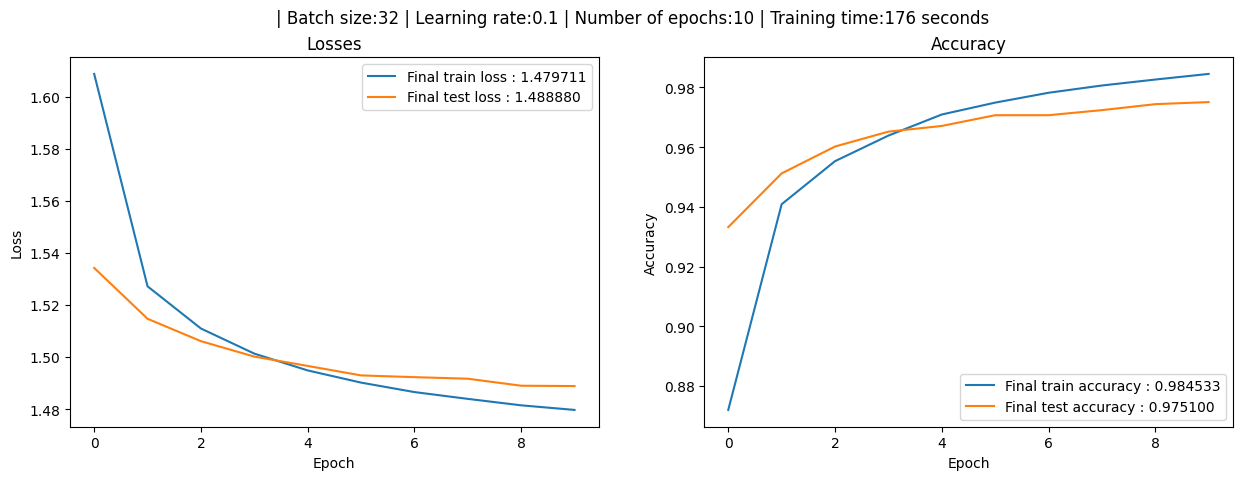

In [ ]:
model_mlp = learning(MLP, 10, 0.1)

## 1.2

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.flat = nn.Flatten()
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(1568, 10) # 1568 = 7*7*32
        self.sm = nn.Softmax(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)

        x = self.flat(x)
        x = self.relu3(x)
        x = self.fc(x)
        x = self.sm(x)

        return x

This network has $(3*3+1)*8 + (3*3+1)*16 + (3*3+1)*32 + (7*7*32)*10 = 16 240$ learnable weights

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 1.497901 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 1.483694 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 1.480240 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.1%, Avg loss: 1.480239 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 1.476287 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 1.475996 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 1.476241 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 1.472688 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 1.473379 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 1.472724 

Done!


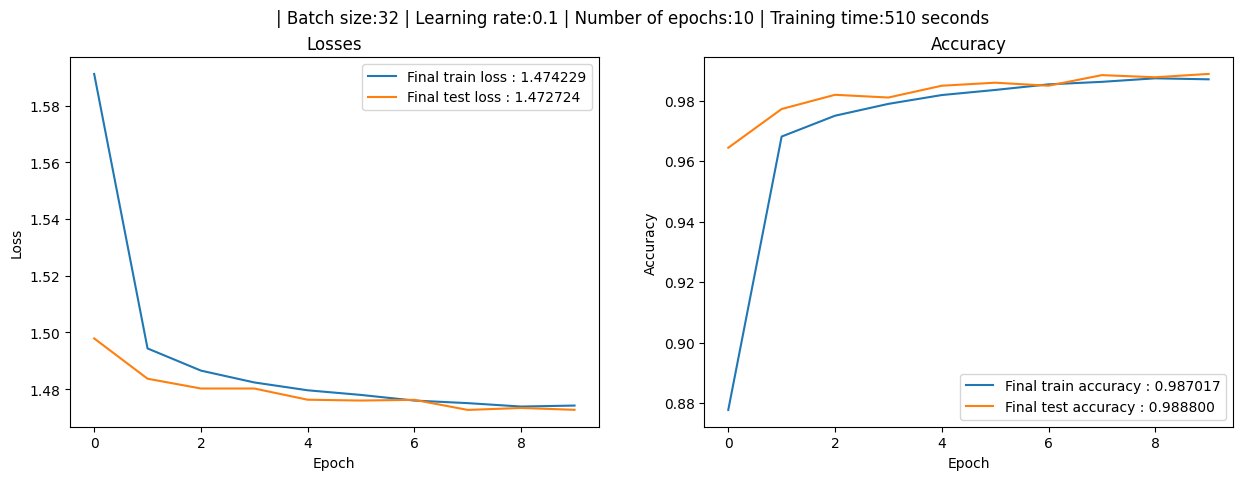

In [ ]:
model_cnn = learning(CNN, 10, 0.1)

##1.3

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.flat = nn.Flatten()
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(1568, 10)
        self.sm = nn.Softmax(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.conv3(x)

        x = self.flat(x)
        x = self.relu3(x)
        x = self.fc(x)
        x = self.sm(x)

        return x

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 1.503285 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.0%, Avg loss: 1.491322 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 1.484956 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 1.484263 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 1.478677 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 1.479982 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 98.4%, Avg loss: 1.477554 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 1.473817 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 1.475700 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98.3%, Avg loss: 1.478022 

Done!


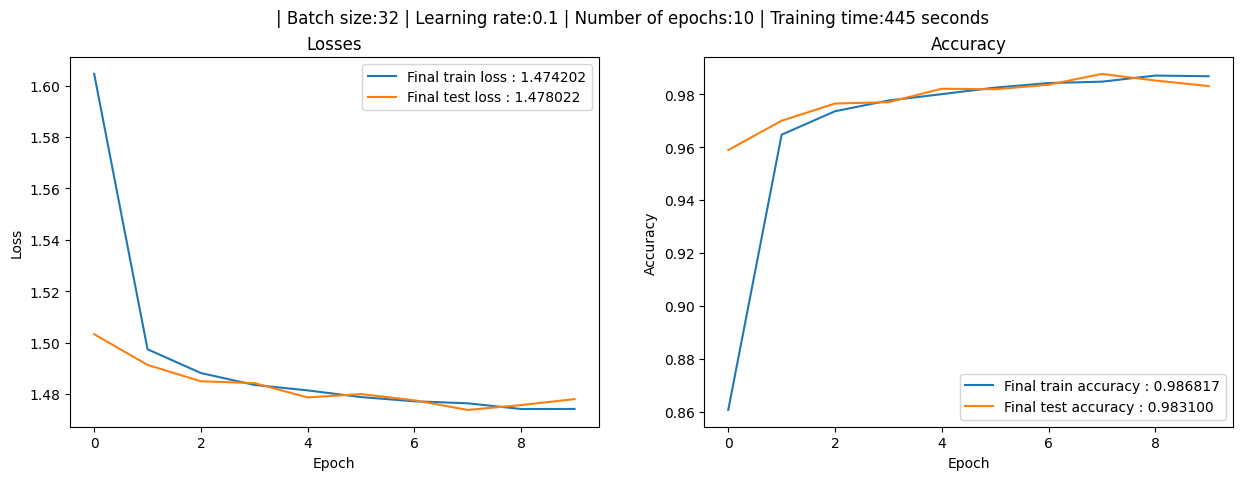

In [ ]:
model_cnn2 = learning(CNN2, 10, 0.1)

In [ ]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.tanh2 = nn.Tanh()
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.flat = nn.Flatten()
        self.tanh3 = nn.Tanh()
        self.fc = nn.Linear(1568, 10)
        self.sm = nn.Softmax(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.tanh1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.tanh2(x)
        x = self.conv3(x)

        x = self.flat(x)
        x = self.tanh3(x)
        x = self.fc(x)
        x = self.sm(x)

        return x

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.5%, Avg loss: 1.524843 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 96.6%, Avg loss: 1.498497 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 1.492433 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.8%, Avg loss: 1.486593 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.9%, Avg loss: 1.484563 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 1.482680 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 98.0%, Avg loss: 1.482938 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 1.479678 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.4%, Avg loss: 1.478417 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 1.478810 

Done!


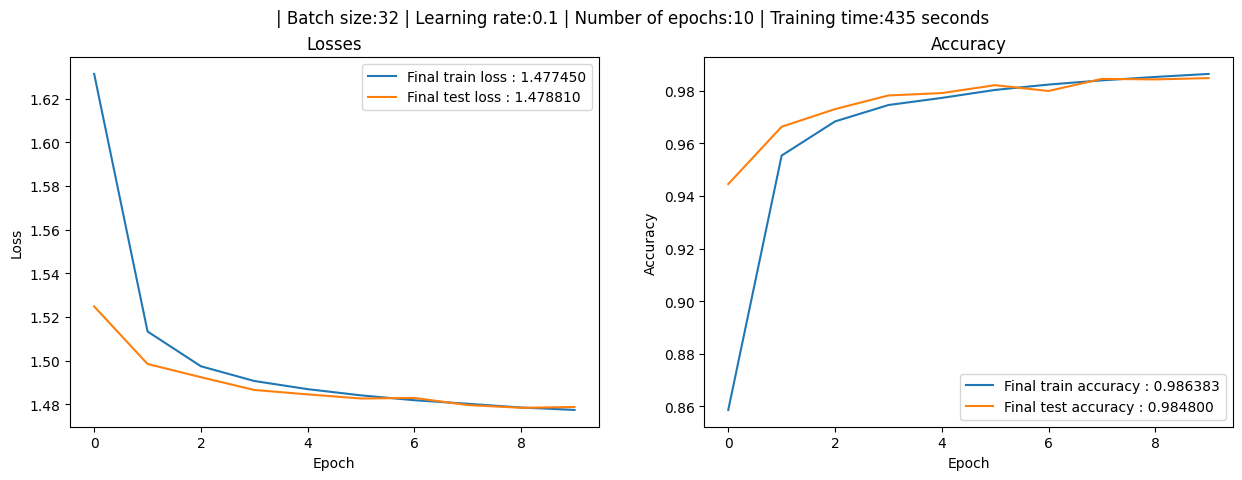

In [ ]:
model_cnn3 = learning(CNN3, 10, 0.1)

##1.4

In [ ]:
def adam_learning(model_class, epochs, lr):
  model = model_class().to(device)
  print(model)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_accuracy, test_accuracy = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_accuracy[t] = train(train_dataloader, model, loss_fn, optimizer)
      test_loss[t], test_accuracy[t] = test(test_dataloader, model, loss_fn)

  end = time.time()
  train_time = end-start
  print("Done!")

  plot_learning(train_loss, test_loss, train_accuracy, test_accuracy, lr, train_time, epochs)

  return model

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh1): Tanh()
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh2): Tanh()
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (tanh3): Tanh()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg loss: 1.499547 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 1.485702 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.9%, Avg loss: 1.482127 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.1%, Avg loss: 1.481086 

Epoch 5
-------------------------------
Tes

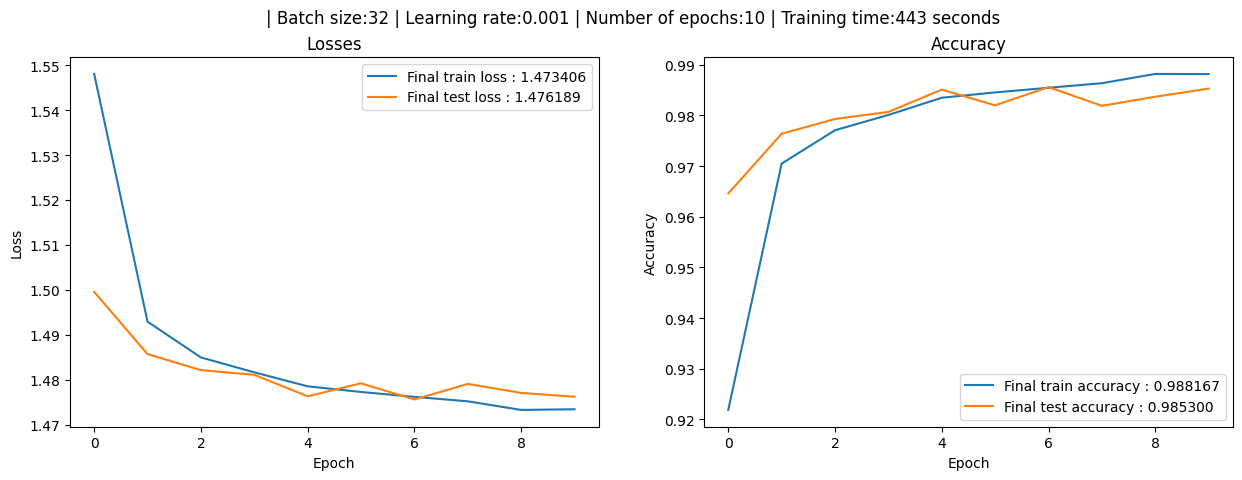

In [ ]:
model_cnn3_bis = adam_learning(CNN3, 10, 0.001)

##1.5

Changes  :   
Learning rate scheduler

Noise layer



###Scheduler

In [ ]:
lr = 0.001
lr_evol = [lr*0.9**i for i in range(20)]

plt.plot(range(1,21),lr_evol)
plt.xlabel("Epoch")
plt.ylabel("Learning rate")

In [ ]:
def adam_scheduled(model_class, epochs, lr):

  model = model_class().to(device)
  print(model)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_accuracy, test_accuracy = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_accuracy[t] = train(train_dataloader, model, loss_fn, optimizer)
      test_loss[t], test_accuracy[t] = test(test_dataloader, model, loss_fn)

      scheduler.step()

  end = time.time()
  train_time = end-start
  print("Done!")

  plot_learning(train_loss, test_loss, train_accuracy, test_accuracy, lr, train_time, epochs)

  return model

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh1): Tanh()
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh2): Tanh()
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (tanh3): Tanh()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 96.6%, Avg loss: 1.497507 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 1.485061 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 1.480614 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.0%, Avg loss: 1.480725 

Epoch 5
-------------------------------
Tes

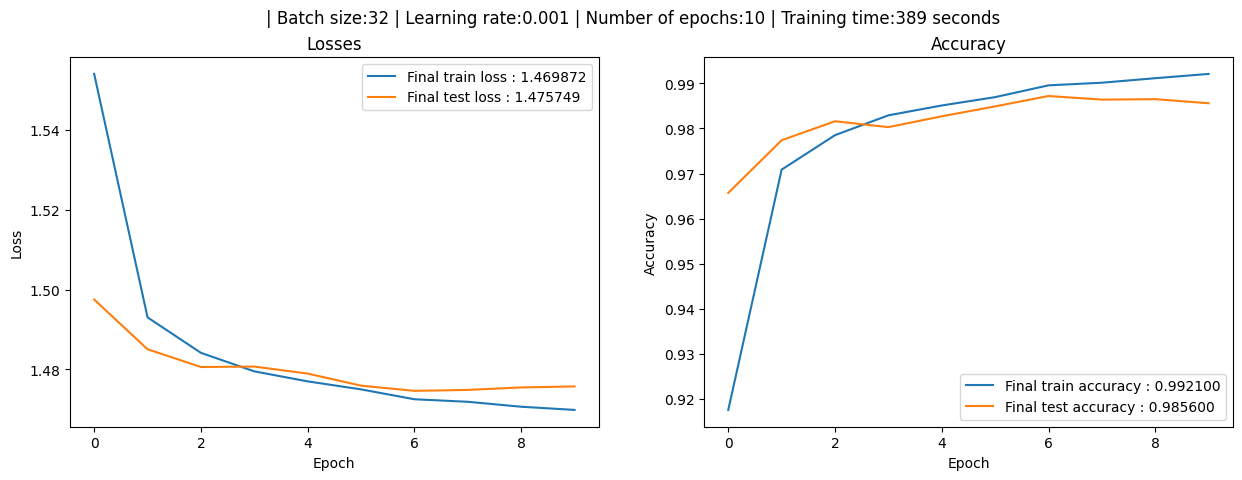

In [ ]:
model_cnn_ter = adam_scheduled(CNN3, 10, 0.001)

###5x5 convolutions

In [ ]:
class CNN_5x5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.tanh2 = nn.Tanh()
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1, padding=2)

        self.flat = nn.Flatten()
        self.tanh3 = nn.Tanh()
        self.fc = nn.Linear(1568, 10)
        self.sm = nn.Softmax(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.tanh1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.tanh2(x)
        x = self.conv3(x)

        x = self.flat(x)
        x = self.tanh3(x)
        x = self.fc(x)
        x = self.sm(x)

        return x

CNN_5x5(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh1): Tanh()
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh2): Tanh()
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (tanh3): Tanh()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 1.491451 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.1%, Avg loss: 1.480487 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 1.485004 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.4%, Avg loss: 1.477424 

Epoch 5
-------------------------------


CNN_5x5(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh1): Tanh()
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (tanh2): Tanh()
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (tanh3): Tanh()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)

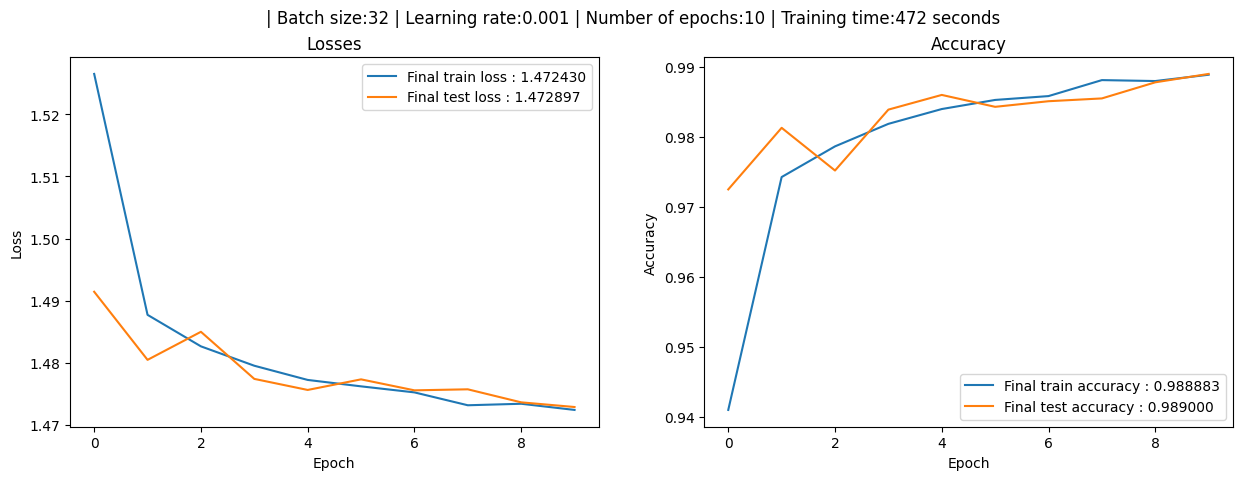

In [ ]:
adam_learning(CNN_5x5, 10, 0.001)

###Sigmoid network

In [ ]:
class CNN_sig(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=1)
        self.sig1 = nn.Sigmoid()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.sig2 = nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)

        self.flat = nn.Flatten()
        self.sig3 = nn.Sigmoid()
        self.fc = nn.Linear(1568, 10)
        self.sm = nn.Softmax(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.sig1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.sig2(x)
        x = self.pool2(x)
        x = self.conv3(x)

        x = self.flat(x)
        x = self.sig3(x)
        x = self.fc(x)
        x = self.sm(x)

        return x

CNN_sig(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sig1): Sigmoid()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sig2): Sigmoid()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (sig3): Sigmoid()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 76.1%, Avg loss: 1.702989 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 86.1%, Avg loss: 1.604761 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 86.8%, Avg loss: 1.594276 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 87.4%, Avg loss: 1.587964 

Epoch 5
--------------------------

CNN_sig(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sig1): Sigmoid()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sig2): Sigmoid()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (sig3): Sigmoid()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (sm): Softmax(dim=1)
)

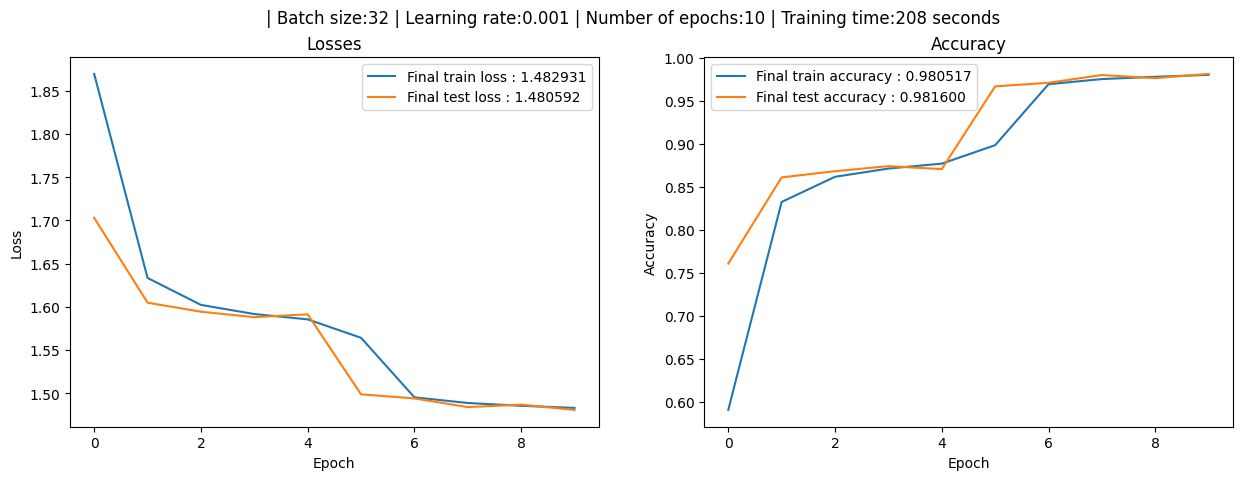

In [ ]:
adam_learning(CNN_sig, 10, 0.001)

###Confusion matrix

In [ ]:
def confusion(trained_model, testloader):
  size = len(testloader.dataset)
  num_batches = len(testloader)

  y_actual = []
  y_pred = []

  with torch.no_grad():
      for X, y in testloader:
          X, y = X.to(device), y.to(device)

          y_actual.extend(y.tolist())

          output = trained_model(X)
          _, pred = torch.max(output, 1)
          y_pred.extend(pred.tolist())

  cm = confusion_matrix(y_actual, y_pred)
  ConfusionMatrixDisplay(cm).plot()
  #plt.title("Confusion Matrix")
  return y_actual, y_pred

In [ ]:
y, y_pred = confusion(model_cnn_ter, test_dataloader)

###Misclassifications

In [ ]:
missmatches = 0

misclass_indices=[]
wrong_predictions = []
right_labels = []

for i in range(len(y)):

  if y[i]!=y_pred[i] :
    misclass_indices.append(i)
    wrong_predictions.append(y_pred[i])
    right_labels.append(y[i])

    missmatches+=1
    if missmatches==10 : break

In [ ]:
counter=0
found=0
index_interest = misclass_indices[found]
allfound=False

fig, axes = plt.subplots(5,2)
fig.set_figheight(20)
fig.set_figwidth(7)

with torch.no_grad():
  for X, y in test_dataloader:
    counter+=32
    if counter < index_interest:
      continue

    X, y = X.to(device), y.to(device)

    X = X.cpu().detach().numpy()

    while counter >= index_interest:
      image = X[index_interest % 32, 0]

      ax = axes[found%5, found%2]

      ax.imshow(image, cmap="gray")

      ax.set_title(f"Actual : {right_labels[found]} | Classified as : {wrong_predictions[found]}")
      ax.axis("off")
      found+=1

      if found==10 :
        allfound=True
        break

      index_interest = misclass_indices[found]

    if allfound : break

#2

##2.1

###Importing data

In [ ]:
from google.colab import drive
import imageio.v3 as iio
import glob

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def normalize_x(x):
  x[1:2] = (x - x.mean(0))[1:2]/x.std(0)[1:2]
  return x

def normalize_y(y):
  y = (y - y.mean(0))/ y.std(0)
  return y

In [ ]:
np_xtrain = np.empty( (85, 3, 128, 128) )
np_ytrain = np.empty((85, 128,128))

np_ytest = np.empty((60, 128,128))
np_xtest = np.empty((60,3, 128,128))

path = "/content/drive/My Drive/M1/Deep Learning for Image Analysis/Assignment 3/WARWICK/Train/"
path_test = "/content/drive/My Drive/M1/Deep Learning for Image Analysis/Assignment 3/WARWICK/Test/"

for i in range(1,86):
  if i <10: stri = "0"+str(i)
  else : stri = str(i)

  x = iio.imread(path+"image_"+stri+".png")
  y = iio.imread(path+"label_"+stri+".png")
  np_xtrain[i-1,:, :, :] = x.T/255
  np_ytrain[i-1,:] = y.T/255

  if i >60 : continue

  y = iio.imread(path_test+"label_"+stri+".png")
  x = iio.imread(path_test+"image_"+stri+".png")
  np_ytest[i-1,:] = y.T/255
  np_xtest[i-1,:] = x.T/255

49


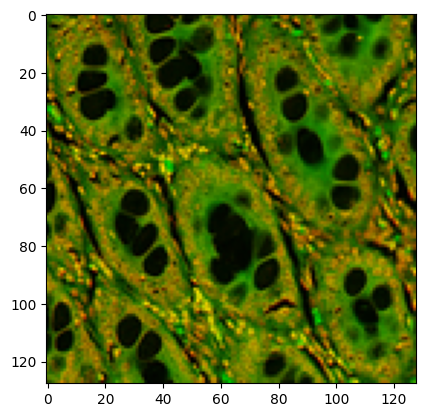

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


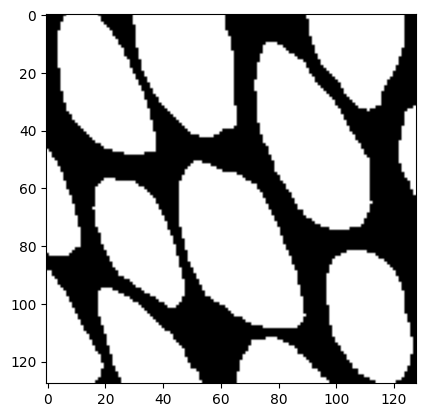

In [ ]:
index = np.random.randint(60)
print(index)

plt.imshow(np_xtest[index].T)
plt.show()
plt.imshow(np_ytest[index].T, cmap="gray")
print(np_ytest[index].T)

In [ ]:
np_xtrain = normalize_x(np_xtrain)
np_xtest = normalize_x(np_xtest)

In [ ]:
means = np.mean(np_xtrain,0)
stds = np.std(np_xtrain,0)

tensor_x = torch.Tensor(np_xtrain)
tensor_y = torch.Tensor(np_ytrain)

tensor_xtest = torch.Tensor(np_xtest)
tensor_ytest = torch.Tensor(np_ytest)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_test = TensorDataset(tensor_xtest, tensor_ytest) # create your datset

In [ ]:
segment_batch_size = 5

segment_trainloader = DataLoader(my_dataset, batch_size=segment_batch_size, shuffle=True) # create your dataloader

segment_testloader = DataLoader(my_test, batch_size=segment_batch_size, shuffle=True) # create your dataloader

###Segmentation adaptations

In [ ]:
loss_segment = nn.BCEWithLogitsLoss()

In [ ]:
def segment_learning(model_class, epochs, lr):
  model = model_class().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_DSC, test_DSC = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_DSC[t] = segment_train(segment_trainloader, model, loss_segment, optimizer)
      test_loss[t], test_DSC[t] = segment_test(segment_testloader, model, loss_segment)
      #scheduler.step()

  end = time.time()
  train_time = end-start
  print("Done!")

  segment_plot_learning(train_loss, test_loss, train_DSC, test_DSC, lr, train_time, epochs)

  return model

In [ ]:
def segment_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()

    losses=np.array([])
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        binary_pred = (pred > 0.5).float()

        loss = loss_fn(pred, y)
        losses=np.append(losses, loss.item())

        correct += DSC(binary_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)

            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    DSC_score = correct / num_batches

    #visualise(np.random.randint(segment_batch_size), binary_pred)

    return np.mean(losses), DSC_score.item()

In [ ]:
def visualise(index, tensor):
    array = tensor.cpu().detach().numpy()

    plt.imshow(array[index].T)
    plt.show()

In [ ]:
def segment_test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            binary_pred = (pred > 0.5).float()

            test_loss += loss_fn(pred, y).item()
            correct += DSC(binary_pred, y)

    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n DSC: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct.item()

In [ ]:
def segment_plot_learning(trainloss, testloss, trainacc, testacc, lr, traintime, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_figwidth(15)
  fig.suptitle(f"| Batch size:{segment_batch_size} | Learning rate:{lr} | Number of epochs:{epochs} | Training time:{int(traintime)} seconds")

  ax1.plot(trainloss, label=f"Final train loss : {trainloss[-1]:f}")
  ax1.plot(testloss, label=f"Final test loss : {testloss[-1]:f}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.set_title("Losses")
  ax1.legend()

  ax2.plot(trainacc, label=f"Final train DSC : {trainacc[-1]:f}")
  ax2.plot(testacc, label=f"Final test DSC : {testacc[-1]:f}")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("DSC(A,B)")
  ax2.set_title("Dice Score")
  ax2.legend()

###Building the network

In [ ]:
class CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.relu3 = nn.ReLU()

        self.tconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.relu4 = nn.ReLU()
        self.tconv2 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)
        self.relu5 = nn.ReLU()
        self.sm = nn.Softmax(1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)

        x = self.tconv1(x)
        x = self.relu4(x)
        x = self.tconv2(x)
        x = self.relu5(x)
        x = self.sig(x)
        x = x.squeeze(dim=1)

        return x #+ (0.01**0.5)*torch.randn(x.shape)

In [ ]:
class shallower_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 50, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.tconv = nn.ConvTranspose2d(50, 1, 4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool(x)

        x = self.tconv(x)
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

In [ ]:
def DSC(a,b):
  """
  Returns the Dice SCore between two tensors
  param a: one of the tensors
  param b: the second tensor
  """
  return 2*torch.sum(a==b) / (a.numel()+b.numel())

In [ ]:
cnn_segment2 = segment_learning(shallower_CNN_segment, 300, 0.001)

Epoch 1
-------------------------------
Test Error: 
 DSC: 50.5%, Avg loss: 0.702477 

Epoch 2
-------------------------------
Test Error: 
 DSC: 50.5%, Avg loss: 0.692740 

Epoch 3
-------------------------------
Test Error: 
 DSC: 53.5%, Avg loss: 0.690382 

Epoch 4
-------------------------------
Test Error: 
 DSC: 55.8%, Avg loss: 0.688545 

Epoch 5
-------------------------------
Test Error: 
 DSC: 57.6%, Avg loss: 0.684524 

Epoch 6
-------------------------------
Test Error: 
 DSC: 57.5%, Avg loss: 0.684201 

Epoch 7
-------------------------------
Test Error: 
 DSC: 57.5%, Avg loss: 0.684626 

Epoch 8
-------------------------------
Test Error: 
 DSC: 57.7%, Avg loss: 0.691192 

Epoch 9
-------------------------------
Test Error: 
 DSC: 58.7%, Avg loss: 0.689790 

Epoch 10
-------------------------------
Test Error: 
 DSC: 57.4%, Avg loss: 0.679761 

Epoch 11
-------------------------------
Test Error: 
 DSC: 58.8%, Avg loss: 0.684497 

Epoch 12
-------------------------------


KeyboardInterrupt: 

In [ ]:
def compare_out(trained_model, index):
  tensor_im = (trained_model(torch.Tensor(np_xtest[index]))>0.5).float()

  im = tensor_im.detach().numpy()

  figure = plt.figure(figsize=(8,3))

  figure.add_subplot(1,3, 1)
  plt.imshow(np_xtest[index].T)
  plt.title("X image")
  plt.axis("off")

  label = np_ytest[index]
  figure.add_subplot(1,3, 2)
  plt.imshow(label.T, "gray")
  plt.title("Label")
  plt.axis("off")

  figure.add_subplot(1,3, 3)
  plt.imshow(im.T, "gray")
  plt.axis("off")
  plt.title("Model prediction")

  dsc = DSC(tensor_im, torch.tensor(label)).item()

  figure.suptitle(f"Test image number {index+1} | Dice Score : {dsc}")

  return dsc

In [ ]:
max=0
min=1
for _ in range(20):
  i = np.random.randint(60)
  tensor_im = (cnn_segment2(torch.Tensor(np_xtest[i]))>0.5).float()
  tensor_label = torch.tensor(np_ytest[i])

  dsc = DSC(tensor_im, tensor_label).item()
  if dsc > max:
    max = dsc
    argmax = i

  if dsc < min:
    min = dsc
    argmin = i

In [ ]:
compare_out(cnn_segment2, argmax)
compare_out(cnn_segment2, argmin)

##2.2

###Noisy input

In [ ]:
def noisy_segment_train(dataloader, model, loss_fn, optimizer, std):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()

    losses=np.array([])
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Adding noise :
        X += (torch.randn(X.shape)*std).to(device)

        # Compute prediction error
        pred = model(X)
        binary_pred = (pred > 0.5).float()

        loss = loss_fn(pred, y)
        losses=np.append(losses, loss.item())

        correct += DSC(binary_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)

            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    DSC_score = correct / num_batches

    #visualise(np.random.randint(segment_batch_size), binary_pred)

    return np.mean(losses), DSC_score.item()

def noisy_segment_learning(model_class, epochs, lr, noise_std):
  model = model_class().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_DSC, test_DSC = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_DSC[t] = noisy_segment_train(segment_trainloader, model, loss_segment, optimizer, noise_std)
      test_loss[t], test_DSC[t] = segment_test(segment_testloader, model, loss_segment)
      #scheduler.step()

  end = time.time()
  train_time = end-start
  print("Done!")

  print(test_DSC)
  print(type(test_DSC))

  segment_plot_learning(train_loss, test_loss, train_DSC, test_DSC, lr, train_time, epochs)

  return model

In [ ]:
noisy_segment_cnn = noisy_segment_learning(shallower_CNN_segment, 300, 0.001, 0.03)

###Dropout

In [ ]:
class dropout_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(16, 50, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.tconv = nn.ConvTranspose2d(50, 1, 4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.pool(x)

        x = self.tconv(x)
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

In [ ]:
dropout_cnn = segment_learning(dropout_CNN_segment, 500, 0.001)

###L2 regularization

In [ ]:
def regu_segment_learning(model_class, epochs, lr, weight_decay):
  model = model_class().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_DSC, test_DSC = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_DSC[t] = segment_train(segment_trainloader, model, loss_segment, optimizer)
      test_loss[t], test_DSC[t] = segment_test(segment_testloader, model, loss_segment)
      #scheduler.step()

  end = time.time()
  train_time = end-start
  print("Done!")

  print(test_DSC)
  print(type(test_DSC))

  segment_plot_learning(train_loss, test_loss, train_DSC, test_DSC, lr, train_time, epochs)

  return model

In [ ]:
regu_segment_cnn = regu_segment_learning(shallower_CNN_segment, 300, 0.001, 0.00005)

# /!\ Work in progress /!\

## 2.3 Skip connections

In [ ]:
class skip_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.tconv1 = nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.tconv2 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x = self.pool1(x1)
        x = self.relu1(x)
        x2 = self.conv2(x)
        x = self.pool2(x2)

        x = self.tconv1(torch.cat((x2,x)))
        x = self.relu3(x)
        x = self.tconv2(torch.cat((x1,x)))
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

In [ ]:
segment_learning(skip_CNN_segment, 300, 0.001)

Epoch 1
-------------------------------


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 64 but got size 32 for tensor number 1 in the list.

##2.4 Residual connections

In [ ]:
class residual_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conf0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)

        self.conv1 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1, padding=1)

        self.pool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.tconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.tconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        print("hello")
        x0 = self.conf0(x)

        x = self.ReLU()

        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)

        x = self.relu(x1) + x0

        x = self.pool1(x)

        x2 = self.conv3(x)
        x2 = self.relu(x2)
        x2 = self.conv4(x2)

        x = self.relu(x2) + x

        x = self.pool2(x)

        x = self.tconv1(x)
        x = self.relu(x)
        x = self.tconv2(x)
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

NameError: name 'nn' is not defined

In [ ]:
segment_learning(residual_CNN_segment, 300, 0.001)

Epoch 1
-------------------------------
hello


RuntimeError: The size of tensor a (16) must match the size of tensor b (3) at non-singleton dimension 1